## Neural Networks for Data Science Applications
### Lab session 2: Linear models for regression and classification

**Contents of the lab session**
+ A linear regression example with manual gradient descent.
+ A logistic regression example with objects from tf.keras.

In [0]:
# Install TensorFlow 2.0
!pip install -q tensorflow==2.0.0

In [0]:
import tensorflow as tf

In [0]:
# This command ensures that the first Matplotlib plot is shown inline
%matplotlib inline

### 1.1 - Load and preprocess data for linear regression

In [0]:
# Import some utility modules from sklearn
from sklearn import datasets, preprocessing, model_selection

In [0]:
# Load a simple regression dataset
boston = datasets.load_boston()

In [0]:
# The dataset is a dictionary
boston.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

In [0]:
# Take the input matrix and the output vector
X = boston['data']
y = boston['target']

In [0]:
# Inspect the shape of the matrix:
# X.shape[0]: number of examples
# X.shape[1]: number of features
X.shape

(506, 13)

In [0]:
y[0:10]

array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9])

In [0]:
y.shape

(506,)

In [0]:
# Useful to do shape computations easily
y = y.reshape(-1, 1)

In [0]:
# Normalize the data
X = preprocessing.scale(X)
y = preprocessing.scale(y)

In [0]:
# Split the data into training and test portions
Xtrain, Xtest, ytrain, ytest = \
            model_selection.train_test_split(X, y)

### 1.2 - Linear regression in TF (low level)

In [0]:
# Define a utility function to initialize the model variables
# Note: we initialize them as small pseudo-random numbers
def model_init(n_features):
  w = tf.Variable(
        tf.random.normal(shape=(n_features, 1), stddev=0.01, dtype=tf.float64), 
      )
  b = tf.Variable(0.0, dtype=tf.float64)
  return w, b

In [0]:
w, b = model_init(13)

In [0]:
# Compute the linear model outputs
def linear_model(x):
  return tf.matmul(x, w) + b

In [0]:
linear_model(Xtrain[0:3])

<tf.Tensor: id=24, shape=(3, 1), dtype=float64, numpy=
array([[0.0190547 ],
       [0.03325769],
       [0.03834291]])>

In [0]:
# A function to compute the squared loss
def squared_loss(ytrue, ypredicted):
  return tf.reduce_mean((ytrue - ypredicted)**2.0)

In [0]:
squared_loss(ytrain, linear_model(Xtrain))

<tf.Tensor: id=1452644, shape=(), dtype=float64, numpy=2722.854309248313>

In [0]:
# Optimization phase

for i in range(1000):
  
  # Step 1: compute the loss
  with tf.GradientTape() as tape:
    ypredicted = linear_model(Xtrain)
    l = squared_loss(ytrain, ypredicted)
    
  # Step 2: compute the gradients
  g = tape.gradient(l, [w, b]) 
  
  # Step 3: do a gradient descent step
  w.assign_sub(0.01 * g[0]) # w = w - \eta * gradient of l w.r.t. w
  b.assign_sub(0.01 * g[1]) # b = b - \eta * gradient of l w.r.t. b

In [0]:
w

<tf.Variable 'Variable:0' shape=(13, 1) dtype=float64, numpy=
array([[-0.05481841],
       [ 0.09820639],
       [-0.02990333],
       [ 0.04727738],
       [-0.19264479],
       [ 0.30978357],
       [-0.02967521],
       [-0.3383542 ],
       [ 0.19877823],
       [-0.16600745],
       [-0.22601543],
       [ 0.0687544 ],
       [-0.37885501]])>

In [0]:
# Check the training loss has decreased
squared_loss(ytrain, linear_model(Xtrain))

<tf.Tensor: id=36048, shape=(), dtype=float64, numpy=0.2557999458656836>

In [0]:
# Check the test loss (almost no overfitting in this scenario)
squared_loss(ytest, linear_model(Xtest))

<tf.Tensor: id=36059, shape=(), dtype=float64, numpy=0.27910240485065635>

In [0]:
# Check that the solution is optimal by computing the closed form solution to the least-squares problem.
# (X.T * X)^-1 * X.T * y
# Note: in realistic situations there are faster and more numerically stable ways of doing this computation.
XX = tf.matmul(X.transpose(), X)
Xy = tf.matmul(X.transpose(), y)
wopt = tf.matmul(tf.linalg.inv(XX), Xy)

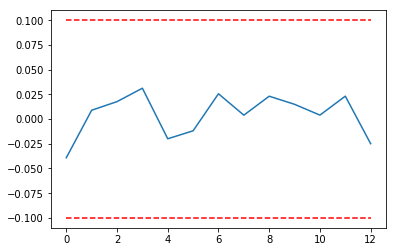

In [0]:
import matplotlib.pyplot as plt
plt.plot(wopt - w)
plt.plot([0, 12], [0.1, 0.1], '--r')
plt.plot([0, 12], [-0.1, -0.1], '--r')

### 1.3 - Load a binary classification dataset

In [0]:
breastcancer = datasets.load_breast_cancer()

In [0]:
X = breastcancer['data']
y = breastcancer['target']

In [0]:
# We do not need to scale the 0/1 y vector
X = preprocessing.scale(X)

In [0]:
X.shape

(569, 30)

In [0]:
y[0:50]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1])

In [0]:
y.dtype

dtype('int64')

In [0]:
# For compatibility with some TF functions, we need np.int32 values
import numpy as np
y = y.reshape(-1, 1).astype(np.int32)

In [0]:
# Split the data, this time with stratification with respect to y, to ensure the same balancing of classes in train and test
Xtrain, Xtest, ytrain, ytest = \
          model_selection.train_test_split(X, y, stratify=y)

### 1.4 - Logistic regression with some tf.keras utilities

In [0]:
w, b = model_init(X.shape[1])

In [0]:
# Simply wrap the output of a linear model in a sigmoid
logreg_model = lambda x: tf.sigmoid(linear_model(x))

In [0]:
# tf.keras has a lot of pre-made objects and functions to simplify code development
from tensorflow.keras import losses, optimizers, metrics

In [0]:
# Define a loss
loss = losses.BinaryCrossentropy()
# loss = losses.MeanSquaredError()

In [0]:
# Define an optimizer
# opt = optimizers.SGD(learning_rate=0.01)
opt = optimizers.RMSprop(learning_rate=0.01)

In [0]:
ypredicted = logreg_model(Xtrain)

In [0]:
ypredicted[0:10]

<tf.Tensor: id=1452673, shape=(10, 1), dtype=float64, numpy=
array([[0.46999973],
       [0.4916889 ],
       [0.46146135],
       [0.49145486],
       [0.50755118],
       [0.48121933],
       [0.47787075],
       [0.48504932],
       [0.50930721],
       [0.5083554 ]])>

In [0]:
# Metrics accumulate multiple computations before outputting a result
acc = metrics.BinaryAccuracy()
acc.update_state(ytrain, ypredicted)
acc.result()

<tf.Tensor: id=1452704, shape=(), dtype=float32, numpy=0.46478873>

In [0]:
all_accuracies = []

for i in range(1000):
  
  with tf.GradientTape() as tape:
    ypredicted = logreg_model(Xtrain)
    l = loss(ytrain, ypredicted)
    
  g = tape.gradient(l, [w, b]) 
  opt.apply_gradients([(g[0], w), (g[1], b)]) # This time, we let the optimizer do this step
  # Note: the input is a list of pairs (gradient, variable)
  
  # Compute the train accuracy at every iteration
  acc.reset_states()
  acc.update_state(ytrain, ypredicted)
  all_accuracies.append(acc.result())

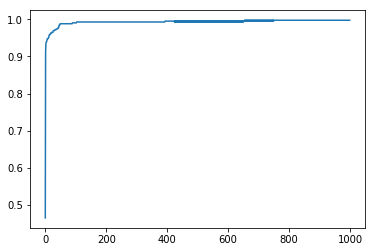

In [0]:
import matplotlib.pyplot as plt
plt.plot(all_accuracies)